In [ ]:
! pip install \
  scprep\
  spacy==2.3.2 \
  sentence_transformers==0.4.0 \
  phate==1.0.4 && \
  python -m spacy download es_core_news_lg

<span style="color:red"><strong>WARNING!</strong></span> Once you installed the packages in the previous cell you must restart your runtime and then import the library and load the model

In [1]:
import spacy
if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")
es_nlp = spacy.load('es_core_news_lg')

Using the GPU


For development work, in case you want to update the files in your GitHub branch by rerunning the clone, you first have to empty the folder.

In [2]:
!rm -rf policy-data-analyzer/

In [3]:
# Define branch to clone
! branch_name='#49-set-up-a-binary-classifier' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 487, done.
remote: Counting objects: 100% (487/487), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 3406 (delta 243), reused 370 (delta 129), pack-reused 2919
Receiving objects: 100% (3406/3406), 155.16 MiB | 35.28 MiB/s, done.
Resolving deltas: 100% (1790/1790), done.
Checking out files: 100% (957/957), done.


In [4]:
import pandas as pd
import sys
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample, losses
from sentence_transformers.evaluation import LabelAccuracyEvaluator
from torch import nn, Tensor
from typing import Iterable, Dict
from torch.utils.data import DataLoader
import math
import time
import cupy as cp
import json

os.chdir("policy-data-analyzer") #If you run this cell more than once, comment out this line because you are ready in this folder and you will get an error
from tasks.data_loader.src.utils import *
from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.evaluate_model.src.model_evaluator import *
from tasks.data_visualization.src.plotting import *

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Fine tune SBERT on Binary Classification

Similar setup for fine tuning multi-class. Maybe we should have this section in the other notebook, and in this one we just load the model? 


In [17]:
class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output


def grid_search_fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=None):
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    all_test_perc = train_params["all_test_perc"]
    model_names = train_params["model_names"]
    start_epochs = train_params["start_epochs"]
    max_num_epochs = train_params["max_num_epochs"]
    epochs_increment = train_params["epochs_increment"]
    numeric_labels = labels2numeric(test_labels, label_names)
    train_params["eval_classifier"] = eval_classifier.__class__.__name__
    print("Grid Search Fine tuning parameters:\n", json.dumps(train_params, indent=4))
    json_output_fname = f"{output_path}/{experiment}_FineTuningResults.json"

    # Output setup - we will update the json as the fine tuning process goes so every result is stored immediately
    with open(json_output_fname, "w") as fw:
        json.dump({}, fw)

    for test_perc in all_test_perc:
        with open(json_output_fname, "r") as fr:
            output = json.load(fr)

        output[f"test_perc={test_perc}"] = {}
        X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                            stratify=train_labels, random_state=69420)

        # Load data samples into batches
        train_batch_size = 16
        label2int = dict(zip(label_names, range(len(label_names))))
        train_samples = []
        for sent, label in zip(X_train, y_train):
            label_id = label2int[label]
            train_samples.append(InputExample(texts=[sent], label=label_id))

        # Configure the dev set evaluator - still need to test whether this works
        dev_samples = []
        for sent, label in zip(X_test, y_test):
            label_id = label2int[label]
            dev_samples.append(InputExample(texts=[sent], label=label_id))

        for model_name in model_names:
            # Setup
            output[f"test_perc={test_perc}"][model_name] = []

            # Train set config
            model = SentenceTransformer(model_name)
            train_dataset = SentencesDataset(train_samples, model=model)
            train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

            # Define the way the loss is computed
            classifier = SoftmaxClassifier(model=model,
                                           sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                           num_labels=len(label2int))

            # Dev set config
            dev_dataset = SentencesDataset(dev_samples, model=model)
            dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
            dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')

            for num_epochs in range(start_epochs, max_num_epochs + 2, epochs_increment):
                warmup_steps = math.ceil(
                    len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
                model_deets = f"{train_params['eval_classifier']}_model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

                # Train the model
                start = time.time()
                if num_epochs == start_epochs:
                    model.fit(train_objectives=[(train_dataloader, classifier)],
                              evaluator=dev_evaluator,
                              epochs=start_epochs,
                              evaluation_steps=1000,
                              warmup_steps=warmup_steps,
                              )
                else:
                    model.fit(train_objectives=[(train_dataloader, classifier)],
                              evaluator=dev_evaluator,
                              epochs=epochs_increment,  # We always tune on an extra epoch to see the performance gain
                              evaluation_steps=1000,
                              warmup_steps=warmup_steps,
                              )

                end = time.time()
                hours, rem = divmod(end - start, 3600)
                minutes, seconds = divmod(rem, 60)
                print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

                if eval_classifier is None:
                  output = evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                                         model_deets, model_name, num_epochs, numeric_labels, output,
                                         output_path, test_perc, json_output_fname)
                else:
                  output = evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents, test_labels,
                                           label_names, experiment, model_deets, model_name, num_epochs, output,
                                           test_perc, output_path, json_output_fname)


def fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=None):
    output_path = train_params["output_path"]
    experiment = train_params["experiment"]
    test_perc = train_params["test_perc"]
    model_name = train_params["model_names"]
    num_epochs = train_params["num_epochs"]
    numeric_labels = labels2numeric(test_labels, label_names)
    train_params["eval_classifier"] = eval_classifier.__class__.__name__
    print("Fine tuning parameters:\n", json.dumps(train_params, indent=4))
    json_output_fname = f"{output_path}/{experiment}_FineTuningResults.json"

    output = {f"test_perc={test_perc}": {}}
    X_train, X_test, y_train, y_test = train_test_split(train_sents, train_labels, test_size=test_perc,
                                                        stratify=train_labels, random_state=69420)
    # Load data samples into batches
    train_batch_size = 16
    label2int = dict(zip(label_names, range(len(label_names))))
    train_samples = []
    for sent, label in zip(X_train, y_train):
        label_id = label2int[label]
        train_samples.append(InputExample(texts=[sent], label=label_id))

    # Configure the dev set evaluator - still need to test whether this works
    dev_samples = []
    for sent, label in zip(X_test, y_test):
        label_id = label2int[label]
        dev_samples.append(InputExample(texts=[sent], label=label_id))

    # Setup
    output[f"test_perc={test_perc}"][model_name] = []

    # Train set config
    model = SentenceTransformer(model_name)
    train_dataset = SentencesDataset(train_samples, model=model)
    train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=train_batch_size)

    # Define the way the loss is computed
    classifier = SoftmaxClassifier(model=model,
                                   sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                   num_labels=len(label2int))

    # Dev set config
    dev_dataset = SentencesDataset(dev_samples, model=model)
    dev_dataloader = DataLoader(dev_dataset, shuffle=True, batch_size=train_batch_size)
    dev_evaluator = LabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier, name='lae-dev')
    warmup_steps = math.ceil(
        len(train_dataset) * num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up
    model_deets = f"{train_params['eval_classifier']}_model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"

    # Train the model
    start = time.time()
    model.fit(train_objectives=[(train_dataloader, classifier)],
              evaluator=dev_evaluator,
              epochs=num_epochs,
              evaluation_steps=1000,
              warmup_steps=warmup_steps,
              output_path=output_path
              )

    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Time taken for fine-tuning:", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

    if eval_classifier is None:
      output = evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                             model_deets, model_name, num_epochs, numeric_labels, output,
                             output_path, test_perc, json_output_fname)
    else:
      output = evaluate_using_sklearn(eval_classifier, model, train_sents, train_labels, test_sents, test_labels,
                               label_names, experiment, model_deets, model_name, num_epochs, output,
                               test_perc, output_path, json_output_fname)


def evaluate_using_sbert(model, test_sents, test_labels, label_names, experiment,
                         model_deets, model_name, num_epochs, numeric_labels, output,
                         output_path, test_perc, json_output_fname):

    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(test_sents, 50, es_nlp, model, 0.01))
    test_embs = encode_all_sents(test_sents, model, proj_matrix)
    label_embs = encode_labels(label_names, model, proj_matrix)
    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")
    model_preds, model_scores = calc_all_cos_similarity(test_embs, label_embs, label_names)

    print("Evaluating predictions...")
    numeric_preds = labels2numeric(model_preds, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_labels, y_pred=numeric_preds)
    output[f"test_perc={test_perc}"][model_name].append(
            {"num_epochs": num_epochs,
             "avg_f1": evaluator.avg_f1.tolist()})

    with open(json_output_fname, "w") as fw:
        json.dump(output, fw)
    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return output


def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, experiment, model_deets, model_name, num_epochs, output,
                        test_perc, output_path, json_output_fname):

    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                            store_name=f"{output_path}/{model_deets}")

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    output[f"test_perc={test_perc}"][model_name].append({"num_epochs": num_epochs, "avg_f1": evaluator.avg_f1.tolist()})
    with open(json_output_fname, "w") as fw:
        json.dump(output, fw)

    evaluator.plot_confusion_matrix(color_map='Blues', exp_name=f"{output_path}/{model_deets}")
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return output

def load_dataset(data_path, rater, set_of_labels_string):
  """
  Return the train data, train labels, test data, and test labels 
  """
  dataset = []

  for dataset_type in ["train", "test"]:
    for file_type in ["sentences", "labels"]:
      filename = dataset_type + "_" + rater + "_" + set_of_labels_string + "_" + file_type + ".csv"
      file = data_path + "/" + filename
      try:
        data = pd.read_csv(file, index_col=False, header=None)
      except Exception as e:
        if "can't decode byte" in str(e):
          data = pd.read_csv(file, index_col=False, header=None, encoding="ISO-8859-1")
        else:
          raise Exception("Couldn't read file:", file)
      dataset.append(data[0].tolist())  # The data is always the entire first column
  
  return dataset[0], dataset[1], dataset[2], dataset[3]

### Load data

- EXP1 = Binary classification fine tuning using the projection matrix
- EXP3 = Binary classification fine tuning evaluated on LightGBM
- EXP4 = Binary classification fine tuning evaluated on Support Vector Machines

In [ ]:
experiment = "EXP30" 

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path =  f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/Binary"
results_save_path = f"{base_path}/Modeling/BinaryClassificationExperiments/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)

In [ ]:
train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
label_names

['not_Incentive', 'Incentive']

In [ ]:
(train_sents[2], train_labels[2]), (test_sents[2], test_labels[2])

(('para el aprovechamiento forestal, y para la realizacion de obras y actividades relacionadas con dicho aprovechamiento',
  'Incentive'),
 ('Se prohibe la practica de quema en los terrenos forestales y sus colindancias, asi como la instalacion de establecimientos cuyo funcionamiento puede provocar incendios forestales',
  'Incentive'))

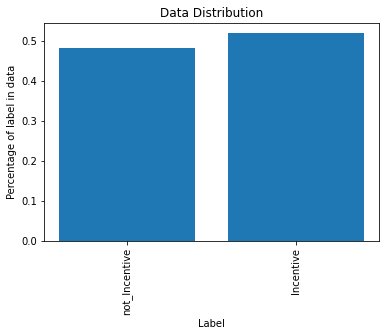

Label counts:
{'not_Incentive': 0.4823008849557522, 'Incentive': 0.5176991150442478}


In [ ]:
numeric_train_labels = labels2numeric(train_labels, label_names)
plot_data_distribution(numeric_train_labels, label_names)

### Temporary text loading

['Incentive', 'not_Incentive']


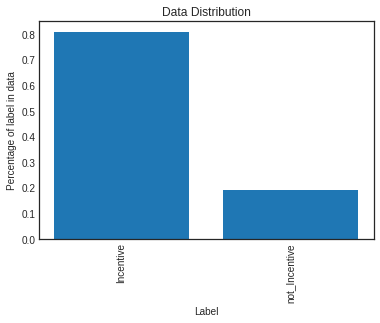

Label counts:
{'Incentive': 0.8081683168316832, 'not_Incentive': 0.19183168316831684}


In [19]:
experiment = "EXP30"
classifier = "Binary"

# This first one is the one used by David and Daniel
base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

# This one is the one used by Jordi
# base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/datasets/{classifier}/"
results_save_path = f"{base_path}/Modeling/MulticlassClassificationExperiments/{experiment}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)

filename = experiment + "_" + "train" + "_sentences.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    train_sents = [item[0] for item in List]

filename = experiment + "_" + "train" + "_labels.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    train_labels = [item[0] for item in List]

filename = experiment + "_" + "test" + "_sentences.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    test_sents = [item[0] for item in List]

filename = experiment + "_" + "test" + "_labels.csv"
file = data_path + filename
with open(file, newline='') as f:
    reader = csv.reader(f)
    List = list(reader)
    test_labels = [item[0] for item in List]
    
label_names = unique_labels(train_labels)
numeric_labels = labels2numeric(test_labels, label_names)
print(label_names)
numeric_train_labels = labels2numeric(train_labels, label_names)
plot_data_distribution(numeric_train_labels, label_names)

### Fine tune SBERT



In [10]:
from lightgbm import LGBMClassifier
from sklearn import svm

In [ ]:
# Configure the grid search fine tuning 
# clf = LGBMClassifier(n_estimators=2000,
#                       feature_fraction=0.06,
#                       bagging_fraction=0.67,
#                       bagging_freq=1,
#                       verbose=0,
#                       n_jobs=6,
#                       random_state=69420)

clf = svm.SVC(gamma=0.001, C=100.)

grid_search_params = {
    "all_test_perc": [0.15, 0.2, 0.25, 0.3],
    "model_names": ['stsb-xlm-r-multilingual', 'paraphrase-xlm-r-multilingual-v1'], #, 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "experiment": experiment,
    # If you want to train for a set number of epochs instead of a range, set all these numbers to be equal
    "start_epochs": 4, 
    "epochs_increment": 2,
    "max_num_epochs": 12,
}

In [ ]:
# To run a grid search over hyperparameters for fine tuning SBERT without storing the model, run:
grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names, eval_classifier=clf)

In [15]:
# Configure the fine tuning for one set of parameters
clf = svm.SVC(gamma=0.001, C=100.)
fine_tuning_params = {
    "test_perc": 0.15,
    "model_names": 'paraphrase-xlm-r-multilingual-v1',
    "output_path": results_save_path,
    "experiment": experiment,
    "num_epochs": 10
}

Fine tuning parameters:
 {
    "test_perc": 0.15,
    "model_names": "paraphrase-xlm-r-multilingual-v1",
    "output_path": "/content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/EXP30",
    "experiment": "EXP30",
    "num_epochs": 10,
    "eval_classifier": "NoneType"
}



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.35it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 15.97it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 18.43it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.29it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.06it/s]



Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 17.67it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 19.90it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.25it/s]



Evaluating:  38%|███▊      | 3/8 [00:00<00:00, 22.66it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 18.02it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.74it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 17.39it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 18.55it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.83it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 15.53it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]



Evaluating:  25%|██▌       | 2/8 [00:00<00:00, 13.72it/s]


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]



Time taken for fine-tuning: 00:02:01.65
Classifying sentences...


100%|██████████| 203/203 [00:05<00:00, 35.71it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 203 samples in 0.000s...
[t-SNE] Computed neighbors for 203 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 203 / 203
[t-SNE] Mean sigma: 9.110739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.775459
[t-SNE] KL divergence after 750 iterations: 0.429961


100%|██████████| 203/203 [00:00<00:00, 13603.08it/s]


Evaluating predictions...
Stored confusion matrix: /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/MulticlassClassificationExperiments/EXP30/NoneType_model=paraphrase-xlm-r-multilingual-v1_test-perc=0.15_n-epoch=10_cm.png


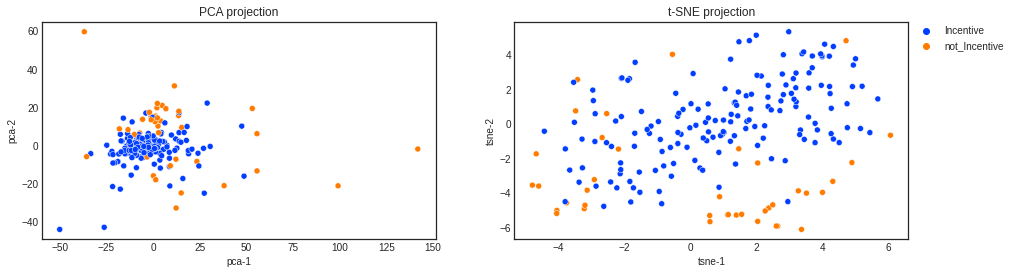

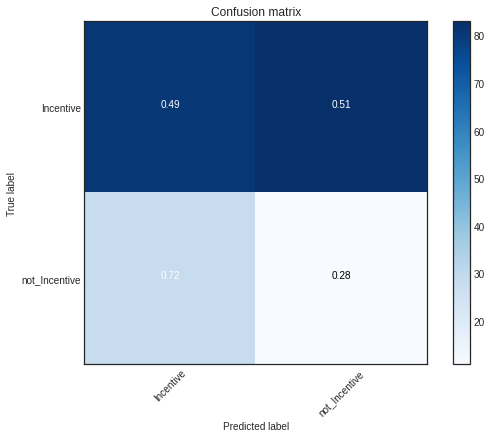

Macro/Weighted Avg F1-score: [0.37941006362058993, 0.5111813258040896]


In [16]:
# If you already know which configuration you want to fine tune SBERT on, and want to store the model, run:
fine_tune_sbert(fine_tuning_params, train_sents, train_labels, test_sents, test_labels, label_names)

## 2. Load fine-tuned model and use embeddings to train a binary classifier

### Load model

In [ ]:
model_name = "stsb-xlm-r-multilingual"
test_perc = 0.3
num_epochs = 4
model_deets = f"model={model_name}_test-perc={test_perc}_n-epoch={num_epochs}"
experiment = "EXP4"
saved_model_path = results_save_path
# saved_model_path = f"/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent/Modeling/FineTuningExperiments/{Experiment}/FineTuning_{model_deets}"

In [ ]:
bin_model = SentenceTransformer(saved_model_path)

### Encode Sentences

First, we will check how good are the fine tuned embeddings without the projection matrix addition

In [ ]:
all_sent_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 306/306 [00:05<00:00, 54.29it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.033s...
[t-SNE] Computed neighbors for 306 samples in 0.217s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 2.491708
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.511703
[t-SNE] KL divergence after 1000 iterations: 0.449039


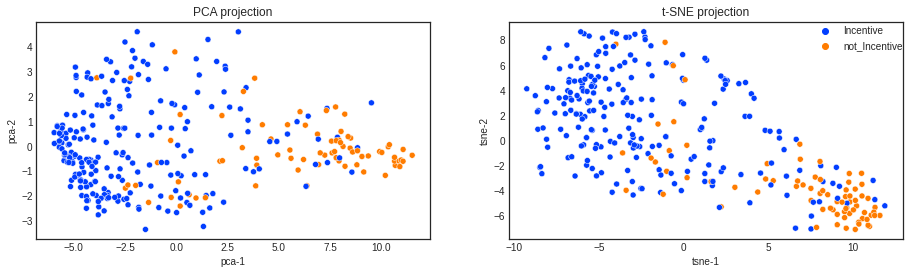

In [ ]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Ok, doesn't look that bad, but not perfect either... The incentives are scattered too much in the space, and the line between non-incentives and incentives is not clearly defined. ***For now, it doesn't matter - but we should experiment more with fine tuning.***.

Now, let's check whether the projection matrix helps:

In [ ]:
proj_matrix = cp.asnumpy(calc_proj_matrix(train_sents, 50, es_nlp, bin_model, 0.01))
all_sent_embs = encode_all_sents(test_sents, bin_model, proj_matrix)

100%|██████████| 306/306 [00:07<00:00, 40.82it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 306 samples in 0.006s...
[t-SNE] Computed neighbors for 306 samples in 0.083s...
[t-SNE] Computed conditional probabilities for sample 306 / 306
[t-SNE] Mean sigma: 20.201386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.918625
[t-SNE] KL divergence after 1000 iterations: 0.734087


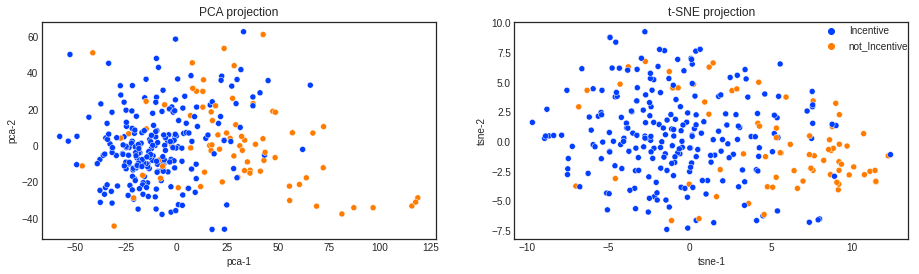

In [ ]:
visualize_embeddings_2D(np.vstack(all_sent_embs), test_labels, tsne_perplexity=50)

Actually, the projection matrix makes things worse. ***Let's NOT use it for now!!!!!***

In [ ]:
# Simple embeddings, no projection matrix added
all_sent_embs = encode_all_sents(train_sents, bin_model)

100%|██████████| 1220/1220 [00:22<00:00, 54.73it/s]


In [ ]:
all_test_embs = encode_all_sents(test_sents, bin_model)

100%|██████████| 306/306 [00:05<00:00, 54.31it/s]


### Train classifiers

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

1. Let's start with Random Forests!

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=69420)

In [ ]:
clf.fit(np.vstack(all_sent_embs), all_labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=69420,
                       verbose=0, warm_start=False)

In [ ]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [ ]:
 print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.89      0.93      0.91       228
not_Incentive       0.76      0.68      0.72        78

     accuracy                           0.86       306
    macro avg       0.83      0.80      0.81       306
 weighted avg       0.86      0.86      0.86       306



In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

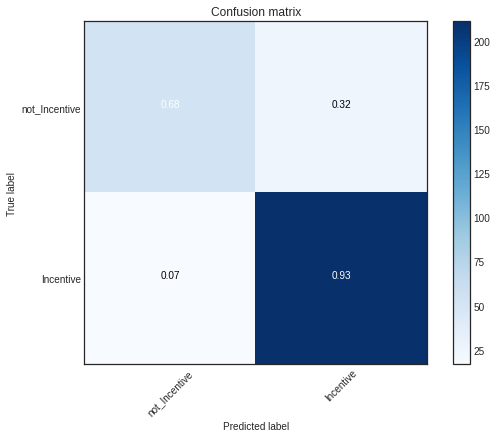

In [ ]:
evaluator.plot_confusion_matrix(color_map='Blues')

Honestly, without Grid Search and 5-fold Cross Validation, these are not bad results... We should add those though!

2. Now, we're gonna try Support Vector Machines

In [ ]:
from sklearn import svm

In [ ]:
clf = svm.SVC(gamma=0.001, C=100.)

In [ ]:
clf.fit(np.vstack(all_sent_embs), all_labels)

SVC(C=100.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
clf_preds = [clf.predict(sent_emb)[0] for sent_emb in all_test_embs]

In [ ]:
numeric_preds = labels2numeric(clf_preds, label_names)
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

In [ ]:
print(classification_report(test_labels, clf_preds))

               precision    recall  f1-score   support

    Incentive       0.91      0.92      0.92       228
not_Incentive       0.76      0.74      0.75        78

     accuracy                           0.88       306
    macro avg       0.84      0.83      0.84       306
 weighted avg       0.87      0.88      0.88       306



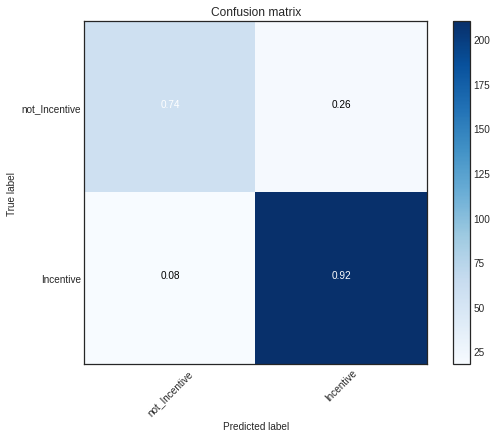

In [ ]:
evaluator.plot_confusion_matrix(color_map='Blues')

Ok, so SVMs are slightly better than Random Forests at ***differentiating*** text! There's a 1-2% decrease in performance for the incentive class, but a 6% gain in non-incentives. If these results remain when doing cross validation and grid search, then I'd recommend going for the SVMs.


**Next steps:**
- Add Grid Search Cross Validation from sklearn

### What about... Beto?
I downloaded the weights and placed them in the folder below: 

In [ ]:
!pip install transformers

In [ ]:
beto_path = f"{base_path}/Modeling/BETO/pytorch/"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification

***IMPORTANT:*** I was not able to figure out a way of using the fine tuning results from the models above so I'm gonna use BETO out of the box, for both encoding/classification and see how it goes.

The following cells are a demo of how the model should be put to use - once you understand it, feel free to skip this part!

In [ ]:
tokenizer = BertTokenizer.from_pretrained(beto_path)
model = BertForSequenceClassification.from_pretrained(beto_path)

Some weights of the model checkpoint at /content/drive/MyDrive/WRI-LatinAmerica-Talent/Modeling/BETO/pytorch/ were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificati

In [ ]:
classes = ["no es parafrasis", "es parafrasis"]

sequence_0 = "La compañia Hugging esta basada en Nueva York"
sequence_1 = "Las manzanas son malas para la salud"
sequence_2 = "La sede principal de Hugging esta en Manhattan"

paraphrase = tokenizer(sequence_0, sequence_2, return_tensors="pt")
not_paraphrase = tokenizer(sequence_0, sequence_1, return_tensors="pt")

paraphrase_classification_logits = model(**paraphrase).logits
not_paraphrase_classification_logits = model(**not_paraphrase).logits

paraphrase_results = torch.softmax(paraphrase_classification_logits, dim=1).tolist()[0]
not_paraphrase_results = torch.softmax(not_paraphrase_classification_logits, dim=1).tolist()[0]

In [ ]:
print(">>> Deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(paraphrase_results[i] * 100))}%")

print("\n>>> NO deberia de ser parafrasis:")
for i in range(len(classes)):
  print(f"{classes[i]}: {int(round(not_paraphrase_results[i] * 100))}%")

>>> Deberia de ser parafrasis:
no es parafrasis: 41%
es parafrasis: 59%

>>> NO deberia de ser parafrasis:
no es parafrasis: 61%
es parafrasis: 39%


OK! Now it's time to apply it to our data. We will try it out with our test set, just to have a fair comparison

In [ ]:
tokenized_sents = tokenizer(test_sents, padding=True, return_tensors="pt")
clf_logits = model(**tokenized_sents).logits
clf_results = torch.softmax(clf_logits, dim=1).tolist()[0]

In [ ]:
# This stores the index of the highest score - in other words, our label
clf_preds = [np.argmax(logits) for logits in clf_results]

In [ ]:
print(classification_report(test_labels, clf_preds))

In [ ]:
evaluator = ModelEvaluator(label_names, y_true=numeric_test_labels, y_pred=clf_preds)
evaluator.plot_confusion_matrix(color_map='Blues')

1